In [16]:
import matplotlib.pyplot as plt

%matplotlib inline

In [17]:
X = [571, 659, 767, 867, 935, 1083, 1251, 1571, 2175, 4559]
Y = [
    80.05091887735486,
    73.96316801230296,
    64.90688196847367,
    58.991787773933105,
    53.919938485198,
    49.70535947712418,
    46.73351787773933,
    43.76398308342945,
    41.689396386005384,
    37.05990003844675,
]

In [18]:
import numpy as np
A = np.array([22.59345406, 51.27039951, 46.48372633, 42.75860622, 14.93995604])
B = np.array([1.0000454, 8.3890561, 8.3890561, 8.3890561, 1.0000454])

def f(x):
    return np.sum(A*(B ** (-x/1000)))

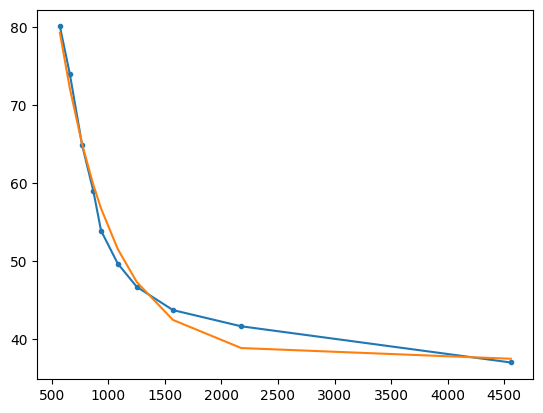

In [19]:
plt.plot(X, Y, marker='.')
plt.plot(X, [f(x) for x in X])